# A better uncertainties estimate for deep neural networks

## Abstract

DNNs are increasingly used in sensitive environments such as healthcare. In these sensitive environments a number of important questions arise. For example we would like to know how certain is our DNN that it has classified correctly if a patient has a disease or not. Not much would be a sensible answer, taking into account that DNNs are massively overparametrised and should overfit by the bias variance tradeoff. Recently in a somewhat distant field there have been lots of works aiming to reduce the number of weights in DNNs with the goal of memory efficiency for mobile applications [1]. Usually pruning results in a loss of accuracy that has to be recovered through finetuning the pruned architecture. This two stage approach, pruning then fine tuning, usually results in networks with up to 90% reduced memory footprint while still achieving the same level of accuracy. This yields an important insight for uncertainty estimation; the many parameters in the original network implied that the classification function was complex and at risk of overfitting, having effectively arrived at the same or a similar function with much fewer parameters implies a much simpler function that is also much less prone to overfitting. This insight has yielded state of the art theoretical results in estimating the ability of the network to generalise to new data [2]. These results are however difficult to interpret for individual data points. Coming back to our original question, in this project the student will take a different perspective allowing them to make estimates of the network uncertainty for specific data samples. The student will have to implement various network pruning techniques and discover whether they result in better uncertainty estimation.

## Introduction


### Libraries

In [1]:
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
from torchvision import datasets
from torchvision import transforms
from torchvision import models
import torch.nn.functional as F

In [2]:
import numpy as np
from scipy.stats import entropy
from random import randrange
from scipy.integrate import simps
from sklearn import linear_model
import os

from tqdm import tqdm_notebook as tqdm

from matplotlib import pyplot as plt
%matplotlib inline  

### Functions

#### Network's informations

In [3]:
def count_parameters(model):
    
    """
    return the total number of parameters of the network
    """
    
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [4]:
def pruning_rate(model):
    
    """
    return the percentage of zeroed connections among all the connections
    """
    
    tot = count_parameters(model)

    pruned = 0
    
    for param in model.parameters():
        if param is not None:
            pruned += param.numel() - param.nonzero().size(0)
            
    return pruned/tot*100

In [5]:
def to_var(x, requires_grad=False):
    
    """
    return the input in Variable format after having applied cuda transformation if possible
    """
    
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, requires_grad=requires_grad)

#### Network's training and evaluation

In [6]:
def train(model, train_loader, test_loader, batch_size, epochs):   
    
    """
    train model on train_loader dataset (with parameters batch_size and epochs) and display
    the accuracy on test_loader dataset after each epoch
    """
    
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-5)

    criterion = nn.CrossEntropyLoss()

    for e in tqdm(range(epochs)):    
        for batch_idx, (x, y) in enumerate(train_loader):
            optimizer.zero_grad()
            x, y = to_var(x), to_var(y)
            out = model(x,False)
            loss = criterion(out, y)
            model.zero_grad()
            loss.backward()
            optimizer.step()

In [7]:
def test_accuracy(model, test_loader,batch_size):
    
    """
    return the accuracy of the model on the test_loader dataset
    """
    
    nb_errors = 0
    for batch_idx, (x, y) in enumerate(test_loader):
        x, y = to_var(x), to_var(y)
        out = model(x,False)
        _, y_hat = out.data.max(1)
        for i in range(len(y)):
            if y.data[i] != y_hat[i]:
                nb_errors = nb_errors + 1
    return 100-(100 * nb_errors) / len(test_set)

In [8]:
def plot_accuracy(model, train_ds, test_ds, validation_ds, epoch, pruning, seed):
  
    acc = np.zeros((3,pruning.shape[0],seed.shape[0])) #numpy array of the accuracy for each set, pruning rate and seed
    datasets = ['train_ds','test_ds','validation_ds']

    for i in range(3): #ds in [train_ds, test_ds, validation_ds]
        for j in range(pruning.shape[0]): #pr in pruning
            for k in range(seed.shape[0]): #s in seed
                model.load_state_dict(torch.load(F"models/{model.get_name()}_pretrain{epoch}_pr{int(pruning[j])}_seed{seed[k]}.pkl"))
                acc[i,j,k] = test_accuracy(model, datasets[i], batch_size)

    plt.figure(figsize=(20,10))

    for i in range(3):
        plt.plot(pruning, acc[i].mean(axis=1))

    plt.legend(['train set', 'test set', 'validation set'])
    plt.xlabel('pruning_rate')
    plt.ylabel('accuracy')
    plt.show()

#### Network's pruning

In [9]:
def prune_one_filter(model, masks):
    
    """
    
    """
    
    NO_MASKS = False
    # construct masks if there is not yet
    if not masks:
        masks = []
        NO_MASKS = True

    values = []
    for p in model.parameters():

        if len(p.data.size()) == 4: # nasty way of selecting conv layer
            p_np = p.data.cpu().numpy()

            # construct masks if there is not
            if NO_MASKS:
                masks.append(np.ones(p_np.shape).astype('float32'))

            # find the scaled l2 norm for each filter this layer
            value_this_layer = np.square(p_np).sum(axis=1).sum(axis=1)\
                .sum(axis=1)/(p_np.shape[1]*p_np.shape[2]*p_np.shape[3])
            # normalization (important)
            value_this_layer = value_this_layer / \
                np.sqrt(np.square(value_this_layer).sum())
            min_value, min_ind = arg_nonzero_min(list(value_this_layer))
            values.append([min_value, min_ind])

    assert len(masks) == len(values), "something wrong here"

    values = np.array(values)

    # set mask corresponding to the filter to prune
    to_prune_layer_ind = np.argmin(values[:, 0])
    to_prune_filter_ind = int(values[to_prune_layer_ind, 1])
    masks[to_prune_layer_ind][to_prune_filter_ind] = 0.

    print('Prune filter #{} in layer #{}'.format(
        to_prune_filter_ind, 
        to_prune_layer_ind))

    return masks


def filter_prune(model, pruning_perc):
    
    '''
    Prune filters one by one until reach pruning_perc
    (not iterative pruning)
    '''
    
    masks = []
    current_pruning_perc = 0.

    while current_pruning_perc < pruning_perc:
        masks = prune_one_filter(model, masks)
        model.set_masks(masks)
        current_pruning_perc = prune_rate(model, verbose=False)
        print('{:.2f} pruned'.format(current_pruning_perc))

    return masks
  
def weight_prune(model, pr, mode): 
    
    """
    return a mask to prune weights whose absolute value is below a treshold computed to reach
    the given pruning rate (pr)
    """
    
    masks = []
    
    if mode == 'local':
        for name, p in model.named_parameters():
            thresh = np.percentile(p.cpu().data.abs().numpy().flatten(), pr)
            if 'weight' in name:
                if len(p.data.size()) != 1:
                    pruned_inds = p.data.abs() > thresh
                    masks.append(pruned_inds.float())
                    
    if mode == 'global':
        all_weights = []
        for p in model.parameters():
            if len(p.data.size()) != 1:
                all_weights += list(p.cpu().data.abs().numpy().flatten())
        thresh = np.percentile(np.array(all_weights), pr)

        for name, p in model.named_parameters():
            if 'weight' in name:
                if len(p.data.size()) != 1:
                    pruned_inds = p.data.abs() > thresh
                    masks.append(pruned_inds.float())
    
    return masks
  
def prune_network(model, train_loader, test_loader, batch_size, epochs, seed, mode = ['weights','local']):
    
    """
    prune the network with various pruning rates from 0% to 100%
    pruning can be made by weights/filters and global/local, default is localy per weights
    
    """
        
    pruning = np.linspace(0,95,20)

    for p in tqdm(pruning):
        if os.path.isfile(F"models/{model.get_name()}_pretrain{epochs}_pr{int(p)}_seed{seed}.pkl"):
            continue
        if p == 0:
            # Load the pretrained model
            model.load_state_dict(torch.load(F"models/{model.get_name()}_pretrain{epochs}_seed{seed}.pkl"))
        else:
            model.load_state_dict(torch.load(F"models/{model.get_name()}_pretrain{epochs}_pr{int(p-5)}_seed{seed}.pkl"))

        # prune the weights
        masks = weight_prune(model, p, mode[1])
        model.set_masks(masks, mode[0])

        acc = test_accuracy(model, test_loader, batch_size)

        # Retraining
        train(model,train_loader, test_loader, batch_size, 10)
        acc = test_accuracy(model, test_loader, batch_size)

        # Save the entire model on Google Drive
        torch.save(model.state_dict(), F"models/{model.get_name()}_pretrain{epochs}_pr{int(p)}_seed{seed}.pkl")

#### Utils

In [10]:
# more efficient version of the above MCDROPOUT
def MCDropout(x, model, batch_size, num_samples=10):
    
    """
    return the pmf of the possible outputs given the input x
    uncertainty is computed using multiple Monte Carlo dropout estimate on model
    """
    
    x = to_var(x)
    
    # Monte Carlo samples from different dropout mask at test time
    mc_samples = np.asarray([np.asarray(model(x, True).cpu().data.argmax(dim=1)) for _ in range(num_samples)
                          ]).reshape(-1, batch_size)
        
    pmf = np.asarray([(mc_samples[:] == k).sum(axis=0)/num_samples for k in range(10)])
        
    return pmf

In [11]:
def access_number(number, iterator):
    
    """
    return a random input of the iterator whose output is number
    """
    
    i = 0
    flag = 0
    random = randrange(100)
    for batch_idx, (x, y) in enumerate(iterator):
        for (x_j,y_j) in zip(x,y):
            if y_j == number:
                if flag == random:
                    return x_j
                flag += 1

In [12]:
def output_distribution(model, x):
    
    """
    plot the probability distribution of the output given input x
    """
    
    # plot probability of each digits for a given input
    plt.bar(range(10),MCDropout(x, model, 1000))
    plt.ylabel('$P(Y = y)$')
    plt.xlabel('y')
    plt.show()

In [13]:
def linear_regression(X,y):
    
    """
    perform a linear regression between X and y and return the corresponding regression line 
    """
    
    regr = linear_model.LinearRegression()
    # Train the model using the training sets
    regr.fit(X, y)

    # Make predictions using the testing set
    return regr.predict(np.linspace(min(X),max(X),100).reshape(-1,1))

In [14]:
def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

#### Uncertainty and pruning analysis

In [ ]:
def save_stats(model, epochs, dataset, name_set, seed, dataset_size, retained_data = 0.5, batch_size = 200):
    
    """
    plot several graphs about uncertainty and retained data vs pruning rates
    """
    
    pruning = np.linspace(0,95,20)
    
    stats = np.zeros((pruning.shape[0],dataset_size,3))

    pruning = np.linspace(0,95,20)
    
    if os.path.isfile(F"stats/{model.get_name()}_pretrain{epochs}_seed{seed}_stats_on_{name_set}.npy"):
        return
        
    for j in np.arange(0,20):

        model.load_state_dict(torch.load(F"models/{model.get_name()}_pretrain{epochs}_pr{int(pruning[j])}_seed{seed}.pkl"))

        if torch.cuda.is_available():
            model.cuda()

        for batch_idx, (x, y) in enumerate(dataset):
            pmf = MCDropout(x, model, batch_size)
            stats[j][batch_idx*batch_size:(batch_idx+1)*batch_size,0] = y
            stats[j][batch_idx*batch_size:(batch_idx+1)*batch_size,1] = pmf.argmax(axis=0)
            stats[j][batch_idx*batch_size:(batch_idx+1)*batch_size,2] = entropy(pmf)      
            
    np.save(F"stats/{model.get_name()}_pretrain{epochs}_seed{seed}_stats_on_{name_set}.npy", stats)
    
    
def save_reference_stats(model, epochs, dataset, name_set, seed, dataset_size, retained_data = 0.5, batch_size = 200):
    
    """
    plot several graphs about uncertainty and retained data vs pruning rates
    """
        
    stats = np.zeros((dataset_size,3))
    
    if os.path.isfile(F"stats/{model.get_name()}_pretrain{epochs}_seed{seed}_stats_on_{name_set}.npy"):
        return
        
    model.load_state_dict(torch.load(F"models/{model.get_name()}_pretrain{epochs}_seed{seed}.pkl"))

    if torch.cuda.is_available():
        model.cuda()

    for batch_idx, (x, y) in enumerate(dataset):
        pmf = MCDropout(x, model, batch_size)
        stats[batch_idx*batch_size:(batch_idx+1)*batch_size,0] = y
        stats[batch_idx*batch_size:(batch_idx+1)*batch_size,1] = pmf.argmax(axis=0)
        stats[batch_idx*batch_size:(batch_idx+1)*batch_size,2] = entropy(pmf)      
            
    np.save(F"stats/{model.get_name()}_pretrain{epochs}_seed{seed}_stats_on_{name_set}.npy", stats)
    
    
def plot_accuracy_vs_pruning_rate_vs_retained_data(model, name_set, epochs, retained_data=0.5):

    plt.figure(figsize=(20,10))  
  
    pruning = np.linspace(0,95,20)
    acc = np.zeros((pruning.shape[0]))
    
    stats = np.load(F"stats/{model.get_name()}_pretrain{str(epochs)}_seed{seed}_stats_on_{name_set}.npy")

    for j in np.arange(0,20):
        ds = stats[j,np.argsort(stats[j,:,2])[:int(retained_data*5000)],:] #p% retained data
        acc[j] = 100*(ds[:,0]==ds[:,1]).sum()/len(ds)
        
    #regression_line = linear_regression(pruning.reshape(-1,1),acc)

    plt.plot(pruning,acc,color='darkblue')
    #plt.plot(np.linspace(min(pruning),max(pruning),100), regression_line, color='royalblue')
    
    acc = np.zeros((pruning.shape[0]))

    for j in np.arange(0,20):
        ds = stats[j,np.argsort(stats[j,:,2])[:int(1*10000)],:] #100% retained data
        acc[j] = 100*(ds[:,0]==ds[:,1]).sum()/len(ds)
        
    #regression_line = linear_regression(pruning.reshape(-1,1),acc)
    
    if epochs > 0 : 
        txt = "w"
    else:
        txt = "w/o"

    plt.plot(pruning,acc,color='darkorange',marker='o')
    #plt.plot(np.linspace(min(pruning),max(pruning),100), regression_line, color='orange')
    
    plt.legend(['50% retained data','100% retained data'])
    plt.xlabel('pruning_rate')
    plt.ylabel('accuracy')
    plt.title(F"{model.get_name()}_{txt}_pretrain")
    plt.show()
    
    
def plot_accuracy_vs_pruning_rate_vs_retained_data_all(model, name_set, epochs, retained_data=0.5):
  
    plt.figure(figsize=(20,10))
    pruning = np.linspace(0,95,20)
    legend = []
    
    for e in epochs:
        acc = np.zeros((pruning.shape[0]))

        stats = np.load(F"stats/{model.get_name()}_pretrain{str(e)}_seed{seed}_stats_on_{name_set}.npy")

        for j in np.arange(0,20):
            ds = stats[j,np.argsort(stats[j,:,2])[:int(retained_data*5000)],:] #p% retained data
            acc[j] = 100*(ds[:,0]==ds[:,1]).sum()/len(ds)


        plt.plot(pruning,acc,marker='o')

        acc = np.zeros((20))

        for j in np.arange(0,20):
            ds = stats[j,np.argsort(stats[j,:,2])[:int(1*5000)],:] #100% retained data
            acc[j] = 100*(ds[:,0]==ds[:,1]).sum()/len(ds)

        plt.plot(pruning,acc,'o')

        if e > 0 : 
            txt = "w"
        else:
            txt = "w/o"

        legend += [F"{model.get_name()}_{txt}_pretrain_0.5_retained_data",F"{model.get_name()}_{txt}_pretrain_1.0_retained_data"]

    plt.legend(legend)
    plt.xlabel('pruning_rate')
    plt.ylabel('accuracy')
    plt.show()
    
def plot_difference_retained_data_vs_pruning_rate(model, name_set, epochs, retained_data=0.5):
  
    plt.figure(figsize=(20,10))
    pruning = np.linspace(0,95,20)
    legend = []
    
    for e in epochs:
        temp = np.zeros((pruning.shape[0]))

        stats = np.load(F"stats/{model.get_name()}_pretrain{str(e)}_seed{seed}_stats_on_{name_set}.npy")

        for j in np.arange(0,20):
            ds = stats[j,np.argsort(stats[j,:,2])[:int(retained_data*5000)],:] #p% retained data
            temp[j] = 100*(ds[:,0]==ds[:,1]).sum()/len(ds)

        acc = np.zeros(pruning.shape[0])

        for j in np.arange(0,20):
            ds = stats[j,np.argsort(stats[j,:,2])[:int(1*5000)],:] #100% retained data
            acc[j] = 100*(ds[:,0]==ds[:,1]).sum()/len(ds)
        
        acc = np.abs(acc-temp)

        plt.plot(pruning,acc,marker='o')

        if e > 0 : 
            txt = "w"
        else:
            txt = "w/o"

        legend += [F"{model.get_name()}_{txt}_pretrain"]

    plt.legend(legend)
    plt.xlabel('pruning rate')
    plt.ylabel('accuracy difference')
    plt.show()

In [ ]:
def save_averaged_behaviour(seed,epoch,model,name, set_size, retained_data=0.5):
  
    """
    average all behaviours from different seeds and plot it
    epochs : number of pre-training epochs
    seed : list of seed used
    """

    behaviour = np.zeros((seed.shape[0], 20))

    for i in np.arange(seed.shape[0]):

        temp = np.zeros((20))

        stats = np.load(F"stats/{model.get_name()}_pretrain{epoch}_seed{seed[i]}_stats_on_{name}.npy")
        stats = stats[:,:set_size,:]

        for j in np.arange(0,20):
            ds = stats[j,np.argsort(stats[j,:,2])[:int(retained_data*set_size)],:] #p% retained data
            temp[j] = 100*(ds[:,0]==ds[:,1]).sum()/len(ds)

        acc = np.zeros((20))

        for j in np.arange(0,20):
            ds = stats[j,np.argsort(stats[j,:,2])[:int(1*set_size)],:] #100% retained data
            acc[j] = 100*(ds[:,0]==ds[:,1]).sum()/len(ds)

        behaviour[i] = temp-acc

    np.save(F"stats/{model.get_name()}_pretrain{epoch}_behaviour_on_{name}_seed{seed[0]}_seed{seed[-1]}.npy", behaviour)    
      
def plot_averaged_behaviour(model, names, epoch, seed):
  
    plt.figure(figsize=(20,10))
    pruning = np.linspace(0,95,20)
    legend = []
    
    for n in names:
        behaviour = np.load(F"stats/{model.get_name()}_pretrain{epoch}_behaviour_on_{n}_seed{seed[0]}_seed{seed[-1]}.npy")
        mu = behaviour.mean(axis=0)
        sigma = behaviour.std(axis=0)
        plt.fill_between(pruning, mu + 2*sigma, mu-2*sigma,alpha=.5)
        plt.plot(pruning, mu, marker='o')

        legend += [n]

    plt.legend(legend)
    plt.xlabel('pruning rate')
    plt.ylabel('accuracy difference')
    plt.show()
    
def plot_accuracy_on_test_and_validation_set(seed, model, epoch, set_size, retained_data=0.5):
  
    behaviour_val_100 = np.zeros((seed.shape[0], 20))
    behaviour_val_p = np.zeros((seed.shape[0], 20))
    behaviour_test_100 = np.zeros((seed.shape[0], 20))
    behaviour_test_p = np.zeros((seed.shape[0], 20))

    pruning = np.linspace(0,95,20)

    for i in np.arange(seed.shape[0]):

        stats = np.load(F"stats/{model.get_name()}_pretrain{epoch}_seed{seed[i]}_stats_on_validation_set.npy")
        stats = stats[:,:set_size,:]

        for j in np.arange(0,20):
            ds = stats[j,np.argsort(stats[j,:,2])[:int(retained_data*set_size)],:] #p% retained data
            behaviour_val_p[i,j] = 100*(ds[:,0]==ds[:,1]).sum()/len(ds)

        for j in np.arange(0,20):
            ds = stats[j,np.argsort(stats[j,:,2])[:int(1*set_size)],:] #100% retained data
            behaviour_val_100[i,j] = 100*(ds[:,0]==ds[:,1]).sum()/len(ds)

        stats = np.load(F"stats/{model.get_name()}_pretrain{epoch}_seed{seed[i]}_stats_on_test_set.npy")
        stats = stats[:,:set_size,:]

        for j in np.arange(0,20):
            ds = stats[j,np.argsort(stats[j,:,2])[:int(retained_data*set_size)],:] #p% retained data
            behaviour_test_p[i,j] = 100*(ds[:,0]==ds[:,1]).sum()/len(ds)

        for j in np.arange(0,20):
            ds = stats[j,np.argsort(stats[j,:,2])[:int(1*set_size)],:] #100% retained data
            behaviour_test_100[i,j] = 100*(ds[:,0]==ds[:,1]).sum()/len(ds)  

    mu_val_p = behaviour_val_p.mean(axis=0)
    mu_val_100 = behaviour_val_100.mean(axis=0)
    mu_test_p = behaviour_test_p.mean(axis=0)
    mu_test_100 = behaviour_test_100.mean(axis=0)

    plt.figure(figsize=(20,10))

    plt.plot(pruning, mu_val_p, pruning, mu_val_100, pruning, mu_test_p, 
           pruning, mu_test_100, marker='o')
    plt.axvline(x=pruning[np.argmax(mu_val_p)],ls='--')

    plt.legend([F"{int(100*retained_data)}% retained data on validation set",
             "100% retained data on validation set",
             F"{int(100*retained_data)}% retained data on test set",
             "100% retained data on test set"])
    plt.xlabel('pruning rate')
    plt.ylabel('accuracy')
    plt.show()
    
def plot_4_points_of_interest(seed, model, epoch, set_size, retained_data=0.5):
  
    # save the 4 points of interest before plotting them
    # we keep all values for validation set even if they aren't useful now

    behaviour_val_50 = np.zeros((seed.shape[0], 20))
    behaviour_val_100 = np.zeros((seed.shape[0], 20))
    behaviour_test_50 = np.zeros((seed.shape[0], 20))
    behaviour_test_100 = np.zeros((seed.shape[0], 20))
    behaviour_ref_test_50 = np.zeros((seed.shape[0]))
    behaviour_ref_test_100 = np.zeros((seed.shape[0]))

    pruning = np.linspace(0,95,20)

    for i in np.arange(seed.shape[0]):

        stats = np.load(F"stats/{model.get_name()}_pretrain{epoch}_seed{seed[i]}_stats_on_validation_set.npy")
        stats = stats[:,:set_size,:]

        for j in np.arange(0,20):
            ds = stats[j,np.argsort(stats[j,:,2])[:int(retained_data*set_size)],:] #p% retained data
            behaviour_val_50[i,j] = 100*(ds[:,0]==ds[:,1]).sum()/len(ds)

        for j in np.arange(0,20):
            ds = stats[j,np.argsort(stats[j,:,2])[:int(1*set_size)],:] #100% retained data
            behaviour_val_100[i,j] = 100*(ds[:,0]==ds[:,1]).sum()/len(ds)

        stats = np.load(F"stats/{model.get_name()}_pretrain{epoch}_seed{seed[i]}_stats_on_test_set.npy")
        stats = stats[:,:set_size,:]

        for j in np.arange(0,20):
            ds = stats[j,np.argsort(stats[j,:,2])[:int(retained_data*set_size)],:] #p% retained data
            behaviour_test_50[i,j] = 100*(ds[:,0]==ds[:,1]).sum()/len(ds)

        for j in np.arange(0,20):
            ds = stats[j,np.argsort(stats[j,:,2])[:int(1*set_size)],:] #100% retained data
            behaviour_test_100[i,j] = 100*(ds[:,0]==ds[:,1]).sum()/len(ds)  
            
        stats = np.load(F"stats/{model.get_name()}_pretrain{100}_seed{seed[i]}_stats_on_test_set.npy")
        stats = stats[:set_size,:]


        ds = stats[np.argsort(stats[:,2])[:int(retained_data*set_size)],:] #p% retained data
        behaviour_ref_test_50[i] = 100*(ds[:,0]==ds[:,1]).sum()/len(ds)

        ds = stats[np.argsort(stats[:,2])[:int(1*set_size)],:] #100% retained data
        behaviour_ref_test_100[i] = 100*(ds[:,0]==ds[:,1]).sum()/len(ds) 

    mu_val_50 = behaviour_val_50.mean(axis=0)
    mu_val_100 = behaviour_val_100.mean(axis=0)
    mu_test_50 = behaviour_test_50.mean(axis=0)
    mu_test_100 = behaviour_test_100.mean(axis=0)

    pr_idx = np.argmax(mu_val_50) #best pruning rate choosed in the validation set

    acc_no_pruning = np.array([behaviour_ref_test_50.mean(axis=0),behaviour_ref_test_100.mean(axis=0)]).round(2)
    acc_best_pruning = np.array([mu_test_50[pr_idx],mu_test_100[pr_idx]]).round(2)


    ind = np.arange(2)  # the x locations for the groups
    width = 0.10  # the width of the bars

    fig, ax = plt.subplots(figsize=(15,10))
    rects1 = ax.bar(ind - width/2, (acc_no_pruning[0],acc_best_pruning[0]), width, 
                  label=F'{int(retained_data*100)}% retained data')
    rects2 = ax.bar(ind + width/2, (acc_no_pruning[1],acc_best_pruning[1]), width, 
                  label='100% retained data')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('accuracy')
    ax.set_title('accuracy by pruning and uncertainty estimate')
    ax.set_xticks(ind)
    ax.set_xticklabels(('no pruning', F'best pruning : {pruning[pr_idx]}%'))
    ax.legend(loc='upper center')

    autolabel(rects1, ax)
    autolabel(rects2, ax)

    fig.tight_layout()

    plt.show()

    return pruning[pr_idx]

In [17]:
def uncertainty_on_interpolation(model, test_loader, epochs, best_pr, seed, num_pairs=100):   
    
    """
    plot the uncertainty estimate (mean) all along the interpolation between pairs of images of test_loader
    """

    pruning = np.array([0,best_pr])
    alpha = np.linspace(0,1,50)

    uncertainty = np.zeros((pruning.shape[0],num_pairs,alpha.shape[0]))

    for j in range(pruning.shape[0]):
        i = np.random.randint(0,seed.shape[0])
        model.load_state_dict(torch.load(F"models/{model.get_name()}_pretrain{epochs}_pr{int(pruning[j])}_seed{seed[i]}.pkl"))

        for k in tqdm(range(num_pairs)):
            n1 = randrange(10)
            n2 = randrange(10)

            while n2 == n1:
                n2 = randrange(10)

            F1 = access_number(n1,test_loader)
            F2 = access_number(n2,test_loader)
            x = []

            for a in alpha:
                x.append(a*F1 + (1-a)*F2)

            x = torch.stack(x)

            uncertainty[j,k] = entropy(MCDropout(x, model, alpha.shape[0]))

    return uncertainty

def plot_interpolation(uncertainty):

    from sklearn.kernel_ridge import KernelRidge
    from sklearn.model_selection import GridSearchCV
    from sklearn.gaussian_process import GaussianProcessRegressor
    from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared

    alpha = np.linspace(0,1,50)

    X = alpha.reshape(-1,1)
    y0 = uncertainty[0].mean(axis=0)
    y1 = uncertainty[1].mean(axis=0)
    X_plot = np.linspace(0, 1, 1000)[:, None]

    gp_kernel = ExpSineSquared(1.0, 1.0, periodicity_bounds=(1e-2, 1e1)) \
      + WhiteKernel(1e-2)
    gpr = GaussianProcessRegressor(kernel=gp_kernel)

    gpr.fit(X, y0)
    y0_gpr, y0_std = gpr.predict(X_plot, return_std=True)

    gpr.fit(X, y1)
    y1_gpr, y1_std = gpr.predict(X_plot, return_std=True)


    # Plot results
    plt.figure(figsize=(20, 10))
    lw = 2
    plt.scatter(X, y0, c='navy', label='no pruning')
    plt.plot(X_plot, y0_gpr, color='royalblue', lw=lw)
    plt.fill_between(X_plot[:, 0], y0_gpr - y0_std, y0_gpr + y0_std, color='deepskyblue',
                   alpha=0.2)
    plt.scatter(X, y1, c='darkred', label='best pruning : 65%')
    plt.plot(X_plot, y1_gpr, color='indianred', lw=lw)
    plt.fill_between(X_plot[:, 0], y1_gpr - y1_std, y1_gpr + y1_std, color='salmon',
                   alpha=0.2)

    plt.xlabel('alpha')
    plt.ylabel('uncertainty')
    plt.legend(loc="best",  scatterpoints=1, prop={'size': 8})
    plt.show()

    return

### Network classes

In [18]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        super(MaskedConv2d, self).__init__(in_channels, out_channels, 
            kernel_size, stride, padding, dilation, groups, bias)
        self.mask_flag = False
    
    def set_mask(self, mask):
        self.mask = Variable(mask, requires_grad=False)
        self.weight.data = self.weight.data*self.mask.data
        self.mask_flag = True
    
    def get_mask(self):
        print(self.mask_flag)
        return self.mask
    
    def forward(self, x):
        if self.mask_flag == True:
            weight = self.weight*self.mask
            return F.conv2d(x, weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)
        else:
            return F.conv2d(x, self.weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)

In [19]:
class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        super(MaskedLinear, self).__init__(in_features, out_features, bias)
        self.mask_flag = False
    
    def set_mask(self, mask):
        self.mask = Variable(mask, requires_grad=False)
        self.weight.data = self.weight.data*self.mask.data
        self.mask_flag = True
    
    def get_mask(self):
        print(self.mask_flag)
        return self.mask
    
    def forward(self, x):
        if self.mask_flag == True:
            weight = self.weight*self.mask
            return F.linear(x, weight, self.bias)
        else:
            return F.linear(x, self.weight, self.bias)

## MNIST

In [29]:
batch_size = 200
epochs = 0
retained_data = 0.5
seed = np.arange(10,20)
mode = ['weights','local']

In [30]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

temp_set = datasets.MNIST('datasets/mnist/', train = True, transform=trans, download = True)
test_set = datasets.MNIST('datasets/mnist/', train = False, transform=trans, download = True)
train_set, validation_set = torch.utils.data.random_split(temp_set, (50000,10000))

test_size = len(test_set)
validation_size = len(validation_set)

train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)
validation_loader = torch.utils.data.DataLoader(dataset=validation_set, batch_size=batch_size, shuffle=False)

print('total training batch number: {}'.format(len(train_loader)))
print('total testing batch number: {}'.format(len(test_loader)))
print('total validation batch number: {}'.format(len(validation_loader)))

total training batch number: 250
total testing batch number: 50
total validation batch number: 50


### MLP

In [32]:
class MLP_128_64_mnist(nn.Module):
    def __init__(self):
        super(MLP_128_64_mnist, self).__init__()
        self.linear1 = MaskedLinear(28*28*1, 128, bias=True)
        self.relu1 = nn.ReLU(inplace=True)
        self.linear2 = MaskedLinear(128, 64, bias=True)
        self.relu2 = nn.ReLU(inplace=True)
        self.linear3 = MaskedLinear(64, 10, bias=True)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x, training):
        out = x.view(x.size(0), -1)
        out = F.dropout(self.relu1(self.linear1(out)), 0.1, training = training)
        out = F.dropout(self.relu2(self.linear2(out)), 0.1, training = training)
        out = F.dropout(self.linear3(out), 0.1, training = training)
        out = self.softmax(out)
        return out
        
    def get_name(self):
        return 'MLP_128_64_mnist'

    def set_masks(self, masks, mode):
        # Should be a less manual way to set masks
        # Leave it for the future
        if mode == 'weights':
            self.linear1.set_mask(masks[0])
            self.linear2.set_mask(masks[1])
            self.linear3.set_mask(masks[2])

#### Benchmark network

In [34]:
epochs = 100

for s in tqdm(np.arange(30,40)):
    torch.manual_seed(s)
    model = MLP_128_64_mnist().cuda()
        
    if os.path.isfile(F"models/{model.get_name()}_pretrain{epochs}_seed{s}.pkl"):
        continue

    train(model,train_loader, test_loader, batch_size, epochs)
    torch.save(model.state_dict(), F"models/{model.get_name()}_pretrain{epochs}_seed{s}.pkl")

#### Pre-training : 30 epochs

In [23]:
for s in tqdm(seed):
    torch.manual_seed(s)
    model = MLP_128_64_mnist().cuda()
        
    if os.path.isfile(F"models/{model.get_name()}_pretrain{epochs}_seed{s}.pkl"):
        continue

    train(model,train_loader, test_loader, batch_size, epochs)
    torch.save(model.state_dict(), F"models/{model.get_name()}_pretrain{epochs}_seed{s}.pkl")

#### Pruning : iteratively and retrained 10 epochs

In [24]:
model = MLP_128_64_mnist().cuda()

for s in tqdm(seed):
    prune_network(model, train_loader, test_loader, batch_size, epochs, s, mode)

#### Uncertainty vs sparsity

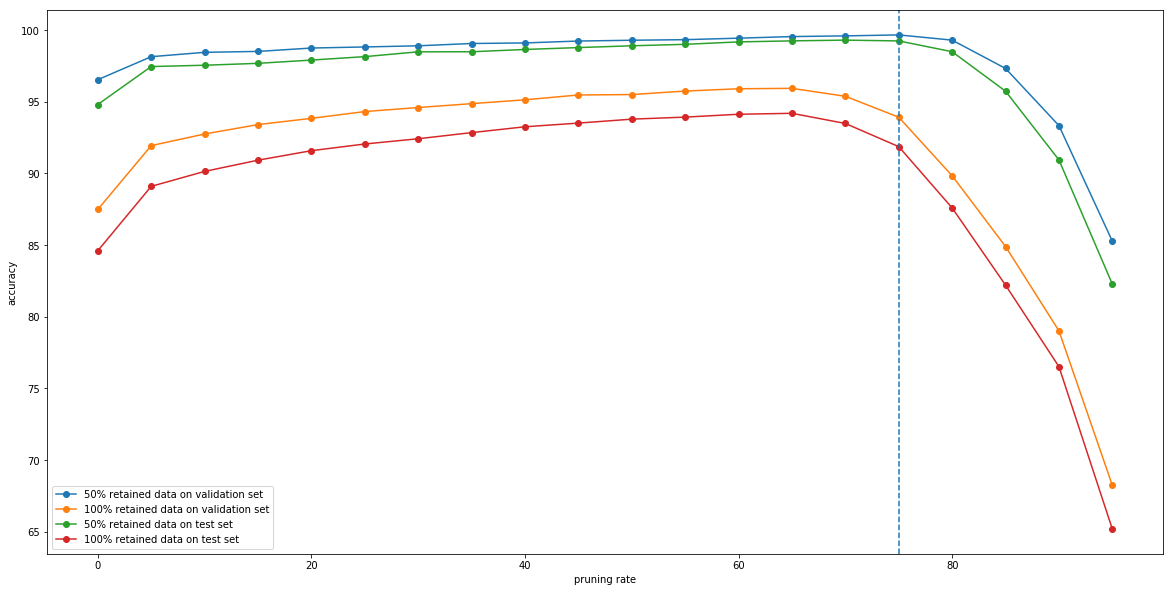

In [29]:
for s in tqdm(seed):
    model = MLP_128_64_mnist().cuda()
    save_stats(model, epochs, test_loader, 'test_set', s, test_size)
    save_stats(model, epochs, validation_loader, 'validation_set', s, validation_size)
    
plot_accuracy_on_test_and_validation_set(seed, model, epochs, test_size)

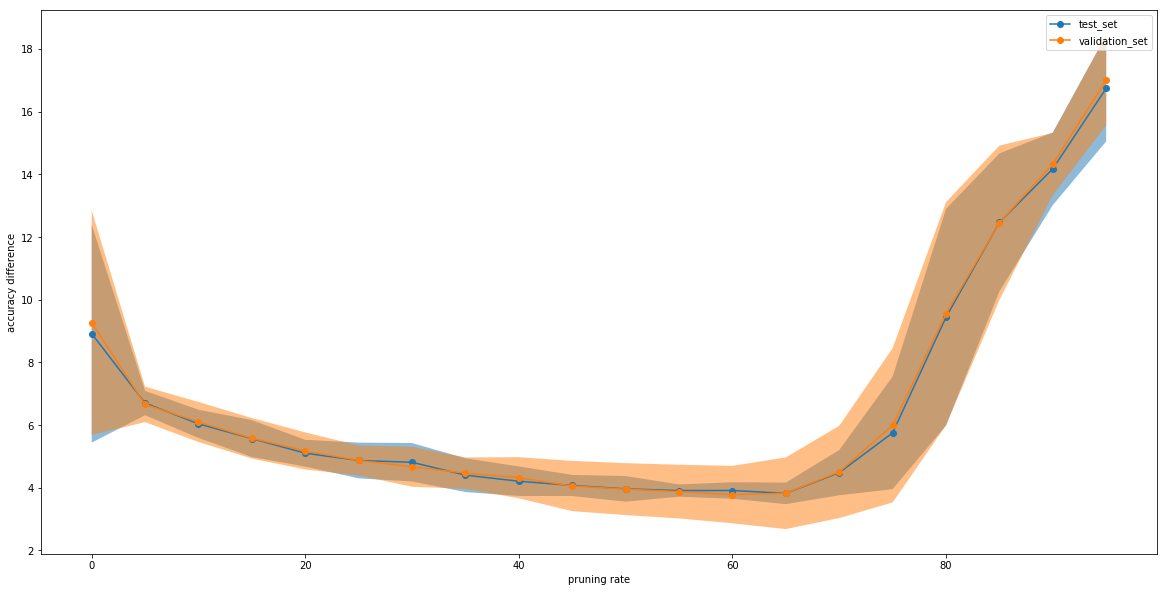

In [35]:
save_averaged_behaviour(seed, epochs, model, 'test_set', test_size)
save_averaged_behaviour(seed, epochs, model, 'validation_set', validation_size)
       
plot_averaged_behaviour(model, ['test_set','validation_set'], epochs, seed)

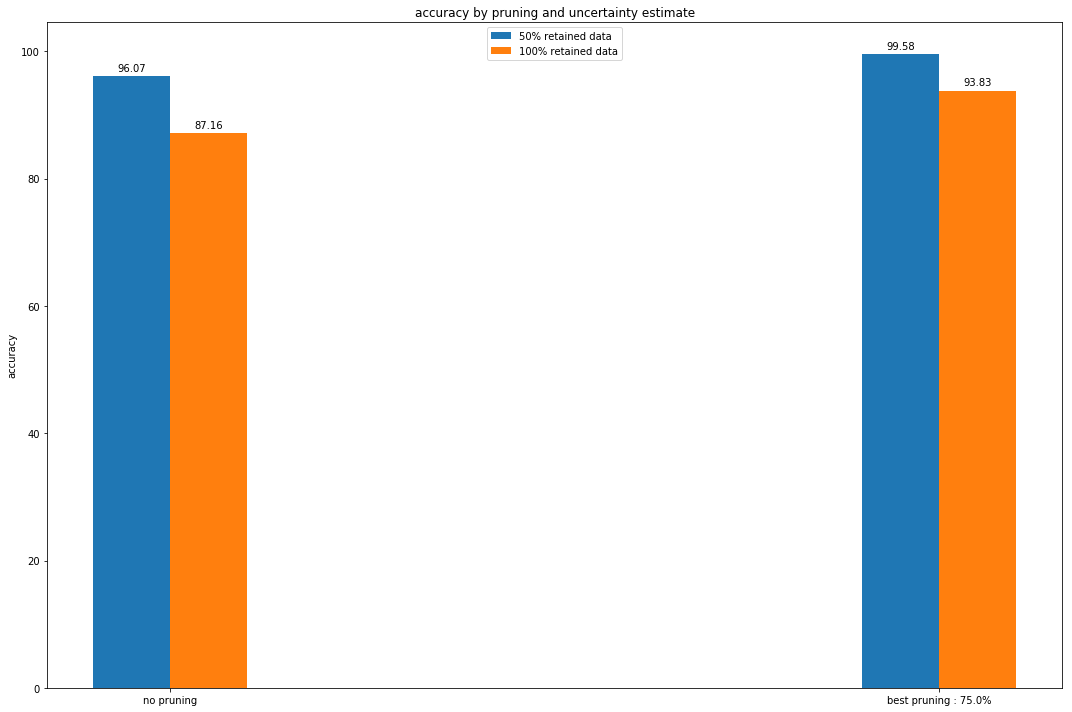

In [36]:
model = MLP_128_64_mnist().cuda()
best_pr = plot_4_points_of_interest(seed, model, epochs, test_size)

#### Interpolation

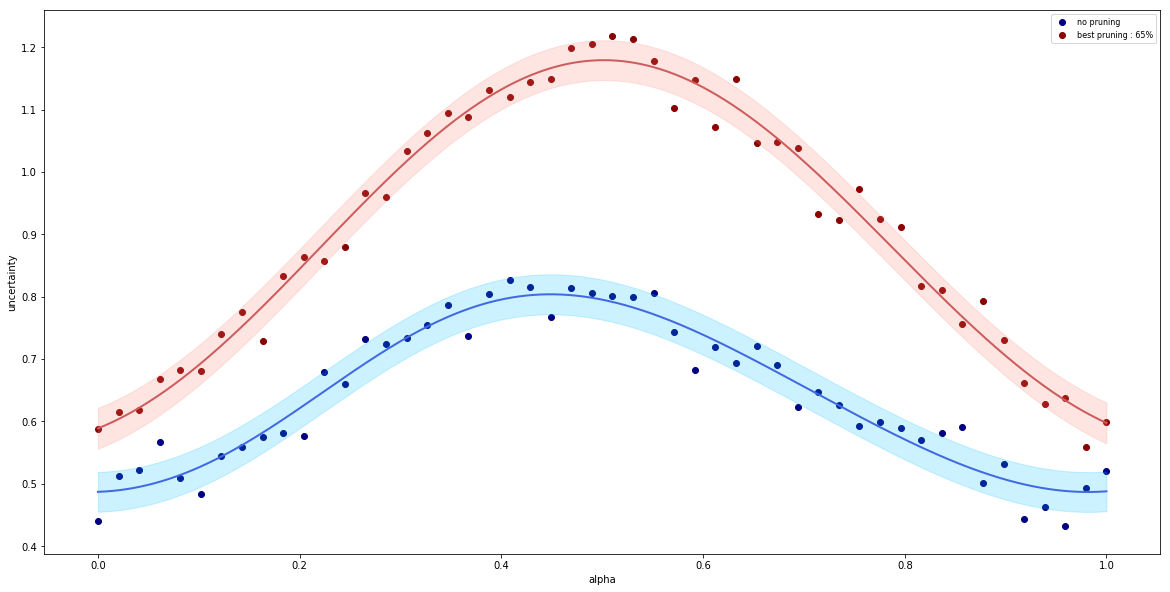

In [37]:
model =  MLP_128_64_mnist().cuda()

uncertainty = uncertainty_on_interpolation(model, test_loader, epochs, best_pr, seed)

plot_interpolation(uncertainty)

### ConvNets

In [39]:
class CNN_64_64_mnist(nn.Module):
    def __init__(self):
        super(CNN_64_64_mnist, self).__init__()

        self.conv1 = MaskedConv2d(1, 64, kernel_size=5, padding=2, stride=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(2)

        self.conv2 = MaskedConv2d(64, 64, kernel_size=5, padding=2, stride=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(2)

        self.linear3 = MaskedLinear(7*7*64,10)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x, training):
        out = self.maxpool1(F.dropout(self.relu1(self.conv1(x)),0.5, training=training))
        out = self.maxpool2(F.dropout(self.relu2(self.conv2(out)),0.5, training=training))
        out = out.view(out.size(0), -1)
        out = F.dropout(self.linear3(out),0.5,training=training)
        out = self.softmax(out)
        return out
    
    def get_name(self):
        return 'CNN_64_64_mnist'

    def set_masks(self, masks, mode):
        # Should be a less manual way to set masks
        # Leave it for the future
        if mode == 'filters':
            self.conv1.set_mask(masks[0])
            self.conv2.set_mask(masks[1])
        if mode == 'weights':
            self.conv1.set_mask(masks[0])
            self.conv2.set_mask(masks[1])
            self.linear3.set_mask(masks[2])

#### Pre-training : 30 epochs

In [40]:
for s in tqdm(seed):
    torch.manual_seed(s)
    model = CNN_64_64_mnist().cuda()
        
    if os.path.isfile(F"models/{model.get_name()}_pretrain{epochs}_seed{s}.pkl"):
        continue

    train(model,train_loader, test_loader, batch_size, epochs)
    torch.save(model.state_dict(), F"models/{model.get_name()}_pretrain{epochs}_seed{s}.pkl")

#### Pruning : iteratively and retrained 10 epochs

In [41]:
model = CNN_64_64_mnist().cuda()

for s in tqdm(seed):
    prune_network(model, train_loader, test_loader, batch_size, epochs, s, mode)

NameError: name 'test_set' is not defined

#### Uncertainty vs sparsity

In [0]:
for s in tqdm(seed):
    model = CNN_64_64_mnist().cuda()
    save_stats(model, epochs, test_loader, 'test_set', s, test_size)
    save_stats(model, epochs, validation_loader, 'validation_set', s, validation_size)
    
plot_accuracy_on_test_and_validation_set(seed, model, epochs, test_size)

In [0]:
save_averaged_behaviour(seed, epochs, model, 'test_set', test_size)
save_averaged_behaviour(seed, epochs, model, 'validation_set', validation_size)
       
plot_averaged_behaviour(model, ['test_set','validation_set'], epochs, seed)

In [0]:
model = CNN_64_64_mnist().cuda()
best_pr = plot_4_points_of_interest(seed, model, epochs, test_size)

#### Interpolation

In [0]:
model = CNN_64_64_mnist().cuda()

uncertainty = uncertainty_on_interpolation(model, test_loader, epochs, best_pr, seed)

plot_interpolation(uncertainty)

## Fashion-MNIST

In [38]:
batch_size = 200
epochs = 0
retained_data = 0.5
seed = np.arange(10,20)
mode = ['weights','local']

In [39]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

temp_set = datasets.FashionMNIST('datasets/fashion_mnist/', train = True, transform=trans, download = True)
test_set = datasets.FashionMNIST('datasets/fashion_mnist/', train = False, transform=trans, download = True)
train_set, validation_set = torch.utils.data.random_split(temp_set, (50000,10000))

test_size = len(test_set)
validation_size = len(validation_set)

train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)
validation_loader = torch.utils.data.DataLoader(dataset=validation_set, batch_size=batch_size, shuffle=False)

print('total training batch number: {}'.format(len(train_loader)))
print('total testing batch number: {}'.format(len(test_loader)))
print('total validation batch number: {}'.format(len(validation_loader)))

total training batch number: 250
total testing batch number: 50
total validation batch number: 50


### MLP

In [40]:
class MLP_128_64_fashion(nn.Module):
    def __init__(self):
        super(MLP_128_64_fashion, self).__init__()
        self.linear1 = MaskedLinear(28*28*1, 128, bias=True)
        self.relu1 = nn.ReLU(inplace=True)
        self.linear2 = MaskedLinear(128, 64, bias=True)
        self.relu2 = nn.ReLU(inplace=True)
        self.linear3 = MaskedLinear(64, 10, bias=True)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x, training):
        out = x.view(x.size(0), -1)
        out = F.dropout(self.relu1(self.linear1(out)), 0.1, training = training)
        out = F.dropout(self.relu2(self.linear2(out)), 0.1, training = training)
        out = F.dropout(self.linear3(out), 0.1, training = training)
        out = self.softmax(out)
        return out
        
    def get_name(self):
        return 'MLP_128_64_fashion'

    def set_masks(self, masks, mode):
        # Should be a less manual way to set masks
        # Leave it for the future
        if mode == 'weights':
            self.linear1.set_mask(masks[0])
            self.linear2.set_mask(masks[1])
            self.linear3.set_mask(masks[2])

In [41]:
epochs = 100

for s in tqdm(np.arange(30,40)):
    torch.manual_seed(s)
    model = MLP_128_64_fashion().cuda()
        
    if os.path.isfile(F"models/{model.get_name()}_pretrain{epochs}_seed{s}.pkl"):
        continue

    train(model,train_loader, test_loader, batch_size, epochs)
    torch.save(model.state_dict(), F"models/{model.get_name()}_pretrain{epochs}_seed{s}.pkl")

#### Pre-training : 30 epochs

In [23]:
for s in tqdm(seed):
    torch.manual_seed(s)
    model = MLP_128_64_fashion().cuda()
    
    if os.path.isfile(F"models/{model.get_name()}_pretrain{epochs}_seed{s}.pkl"):
        continue
        
    train(model,train_loader, test_loader, batch_size, epochs)
    torch.save(model.state_dict(), F"models/{model.get_name()}_pretrain{epochs}_seed{s}.pkl")

#### Pruning : iteratively and retrained 10 epochs

In [24]:
model = MLP_128_64_fashion().cuda()

for s in tqdm(seed):
    prune_network(model, train_loader, test_loader, batch_size, epochs, s, mode)

#### Uncertainty vs sparsity

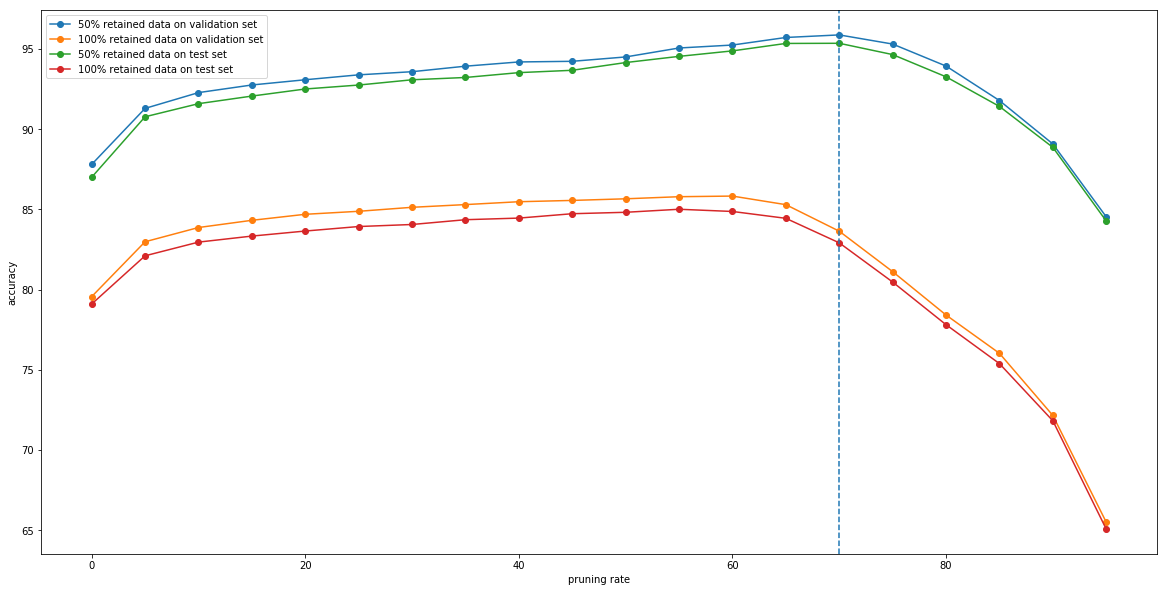

In [27]:
for s in tqdm(seed):
    model = MLP_128_64_fashion().cuda()
    save_stats(model, epochs, test_loader, 'test_set', s, test_size)
    save_stats(model, epochs, validation_loader, 'validation_set', s, validation_size)
    
plot_accuracy_on_test_and_validation_set(seed, model, epochs, test_size)

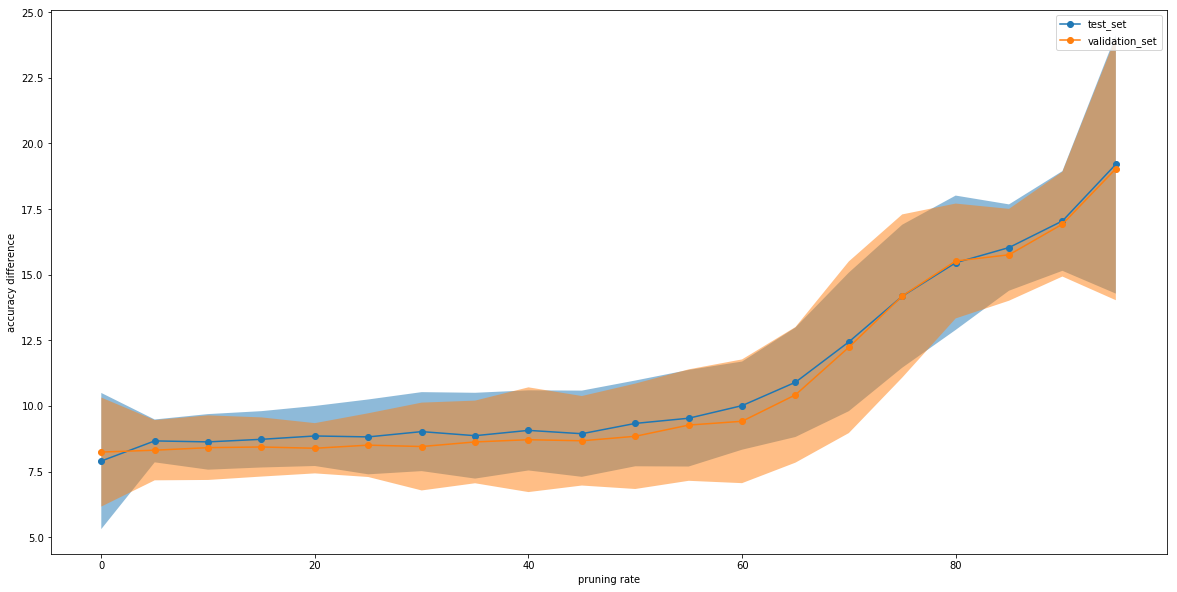

In [28]:
save_averaged_behaviour(seed, epochs, model, 'test_set', test_size)
save_averaged_behaviour(seed, epochs, model, 'validation_set', validation_size)
       
plot_averaged_behaviour(model, ['test_set','validation_set'], epochs, seed)

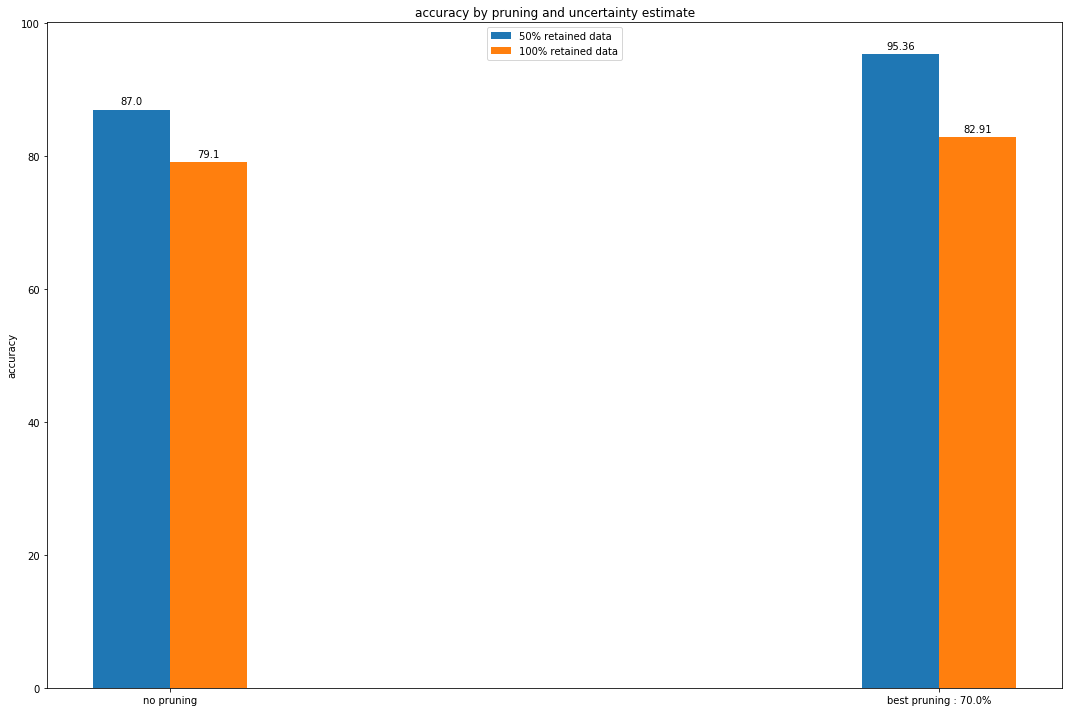

In [26]:
model = MLP_128_64_fashion().cuda()
best_pr = plot_4_points_of_interest(seed, model, epochs, test_size)

#### Interpolation

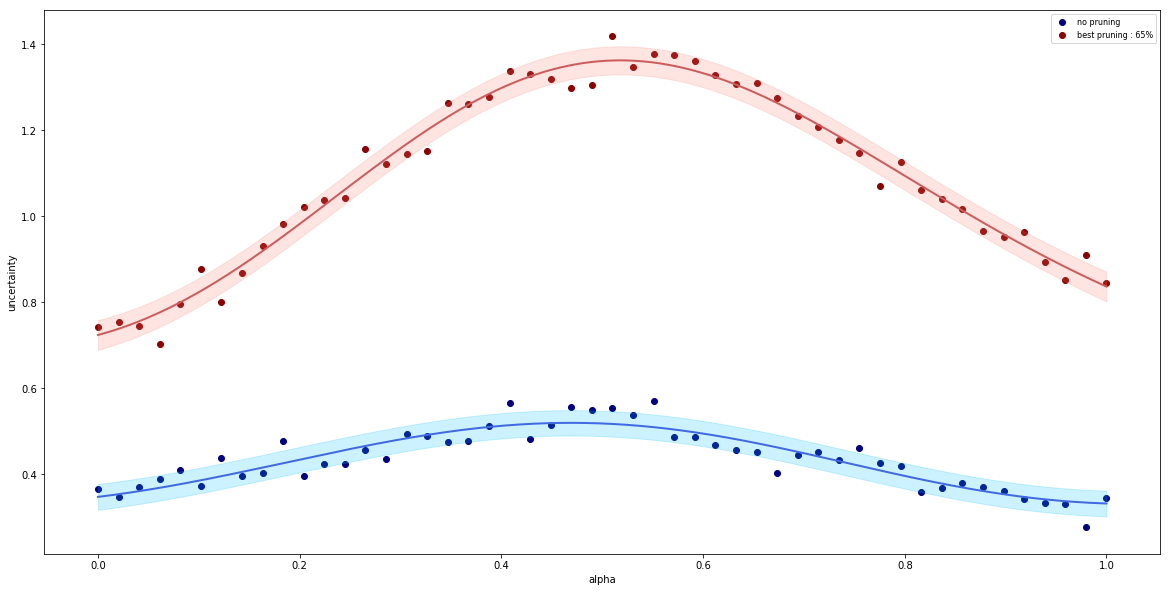

In [27]:
model =  MLP_128_64_fashion().cuda()

uncertainty = uncertainty_on_interpolation(model, test_loader, epochs, best_pr, seed)

plot_interpolation(uncertainty)

### ConvNets

In [ ]:
class CNN_64_64_fashion(nn.Module):
    def __init__(self):
        super(CNN_64_64_fashion, self).__init__()

        self.conv1 = MaskedConv2d(1, 64, kernel_size=5, padding=2, stride=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(2)

        self.conv2 = MaskedConv2d(64, 64, kernel_size=5, padding=2, stride=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(2)

        self.linear3 = MaskedLinear(7*7*64,10)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x, training):
        out = self.maxpool1(F.dropout(self.relu1(self.conv1(x)),0.5, training=training))
        out = self.maxpool2(F.dropout(self.relu2(self.conv2(out)),0.5, training=training))
        out = out.view(out.size(0), -1)
        out = F.dropout(self.linear3(out),0.5,training=training)
        out = self.softmax(out)
        return out
    
    def get_name(self):
        return 'CNN_64_64_fashion'

    def set_masks(self, masks, mode):
        # Should be a less manual way to set masks
        # Leave it for the future
        if mode == 'filters':
            self.conv1.set_mask(masks[0])
            self.conv2.set_mask(masks[1])
        if mode == 'weights':
            self.conv1.set_mask(masks[0])
            self.conv2.set_mask(masks[1])
            self.linear3.set_mask(masks[2])

#### Pre-training : 30 epochs

In [ ]:
for s in tqdm(seed):
    torch.manual_seed(s)
    model = CNN_64_64_fashion().cuda()
    
        if os.path.isfile(F"models/{model.get_name()}_pretrain{epochs}_seed{s}.pkl"):
        continue
    train(model,train_loader, test_loader, batch_size, epochs)
    torch.save(model.state_dict(), F"models/{model.get_name()}_pretrain{epochs}_seed{s}.pkl")

#### Pruning : iteratively and retrained 10 epochs

In [ ]:
model = CNN_64_64_fashion.cuda()

for s in tqdm(seed):
    prune_network(model, train_loader, test_loader, batch_size, epochs, s, mode)

#### Uncertainty vs sparsity

In [ ]:
for s in tqdm(seed):
    model = CNN_64_64_fashion.cuda()
    save_stats(model, epochs, test_loader, 'test_set', s, test_size)
    save_stats(model, epochs, validation_loader, 'validation_set', s, validation_size)
    
plot_accuracy_on_test_and_validation_set(seed, model, epochs, test_size)

In [ ]:
save_averaged_behaviour(seed, epochs, model, 'test_set', test_size)
save_averaged_behaviour(seed, epochs, model, 'validation_set', validation_size)
       
plot_averaged_behaviour(model, ['test_set','validation_set'], epochs,seed)

In [ ]:
model = CNN_64_64_fashion.cuda()
best_pr = plot_4_points_of_interest(seed, model, epochs, test_size)

#### Interpolation

In [ ]:
model = CNN_64_64_fashion.cuda()

uncertainty = uncertainty_on_interpolation(model, test_loader, epochs, best_pr, seed)

plot_interpolation(uncertainty)

## CIFAR-10

In [20]:
batch_size = 200
epochs = 0
retained_data = 0.5
seed = np.arange(10,20)
mode = ['weights','local']

In [21]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

temp_set = datasets.CIFAR10('datasets/cifar/', train = True, transform=trans, download = True)
test_set = datasets.CIFAR10('datasets/cifar/', train = False, transform=trans, download = True)
train_set, validation_set = torch.utils.data.random_split(temp_set, (40000,10000))

test_size = len(test_set)
validation_size = len(validation_set)

train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)
validation_loader = torch.utils.data.DataLoader(dataset=validation_set, batch_size=batch_size, shuffle=False)

print('total training batch number: {}'.format(len(train_loader)))
print('total testing batch number: {}'.format(len(test_loader)))
print('total validation batch number: {}'.format(len(validation_loader)))

Files already downloaded and verified
Files already downloaded and verified
total training batch number: 200
total testing batch number: 50
total validation batch number: 50


### MLP

In [22]:
class MLP_32_64_cifar(nn.Module):
    def __init__(self):
        super(MLP_32_64_cifar, self).__init__()
        self.linear1 = MaskedLinear(32*32*3, 32, bias=True)
        self.relu1 = nn.ReLU(inplace=True)
        self.linear2 = MaskedLinear(32, 64, bias=True)
        self.relu2 = nn.ReLU(inplace=True)
        self.linear3 = MaskedLinear(64, 10, bias=True)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x, training):
        out = x.view(x.size(0), -1)
        out = F.dropout(self.relu1(self.linear1(out)), 0.1, training = training)
        out = F.dropout(self.relu2(self.linear2(out)), 0.1, training = training)
        out = F.dropout(self.linear3(out), 0.1, training = training)
        out = self.softmax(out)
        return out
        
    def get_name(self):
        return 'MLP_32_64_cifar'

    def set_masks(self, masks, mode):
        # Should be a less manual way to set masks
        # Leave it for the future
        if mode == 'weights':
            self.linear1.set_mask(masks[0])
            self.linear2.set_mask(masks[1])
            self.linear3.set_mask(masks[2])

#### Pre-training : 30 epochs

In [23]:
for s in tqdm(seed):
    torch.manual_seed(s)
    model = MLP_32_64_cifar().cuda()
    train(model,train_loader, test_loader, batch_size, epochs)
    torch.save(model.state_dict(), F"models/{model.get_name()}_pretrain{epochs}_seed{s}.pkl")

#### Pruning : iteratively and retrained 10 epochs

In [24]:
model = MLP_32_64_cifar().cuda()

for s in tqdm(seed):
    prune_network(model, train_loader, test_loader, batch_size, epochs, s, mode)

#### Uncertainty vs sparsity

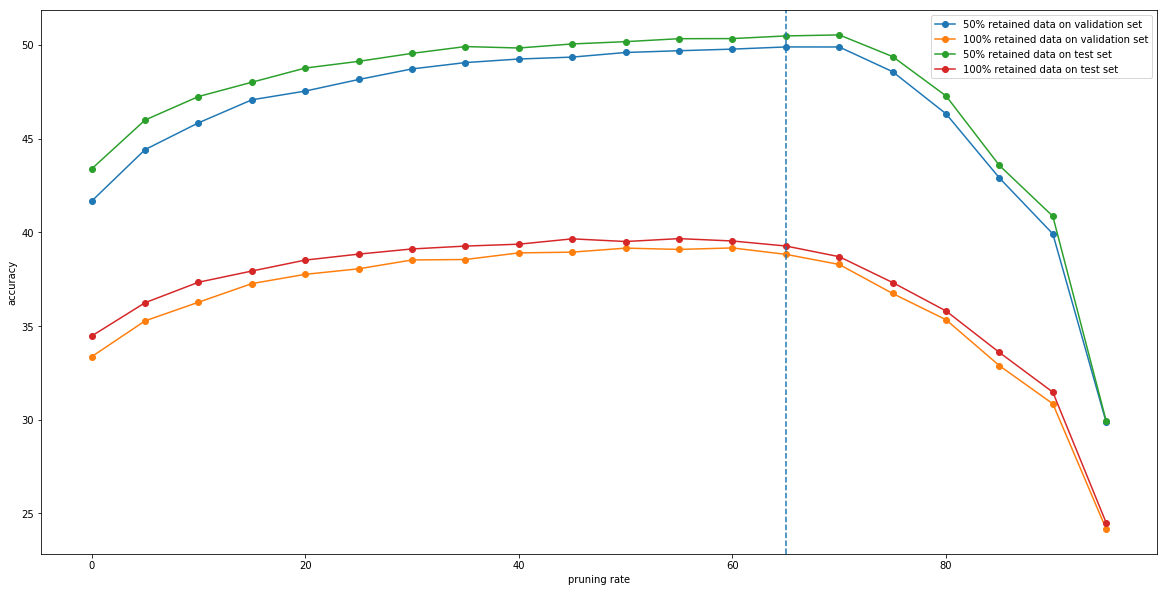

In [25]:
for s in tqdm(seed):
    model = MLP_32_64_cifar().cuda()
    save_stats(model, epochs, test_loader, 'test_set', s, test_size)
    save_stats(model, epochs, validation_loader, 'validation_set', s, validation_size)
    
plot_accuracy_on_test_and_validation_set(seed, model, epochs, test_size)

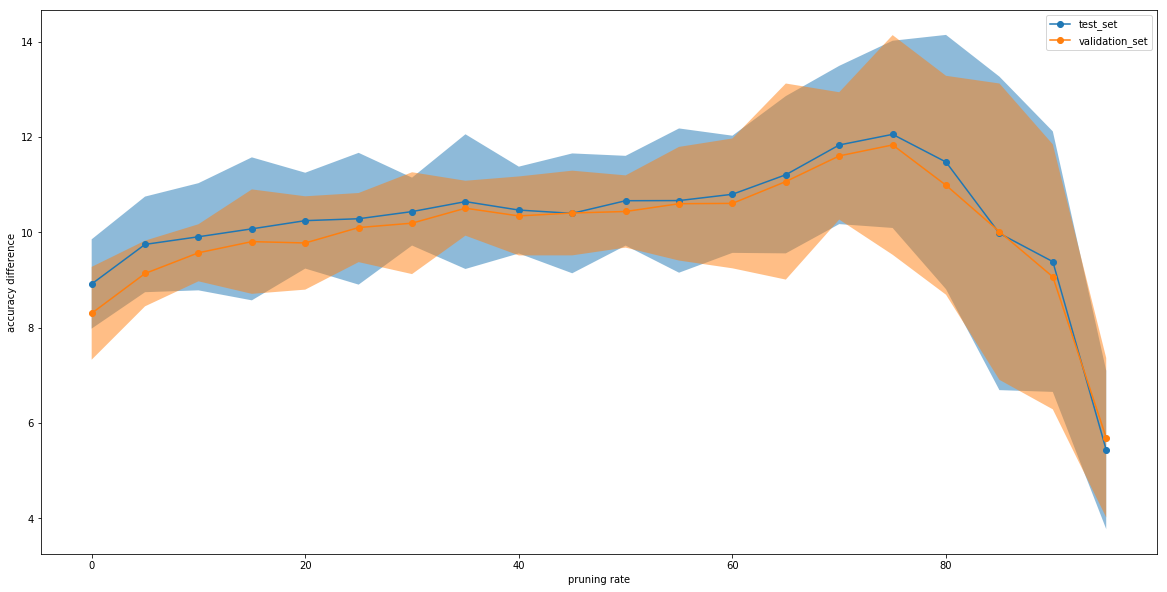

In [26]:
save_averaged_behaviour(seed, epochs, model, 'test_set', test_size)
save_averaged_behaviour(seed, epochs, model, 'validation_set', validation_size)
       
plot_averaged_behaviour(model, ['test_set','validation_set'], epochs,seed)

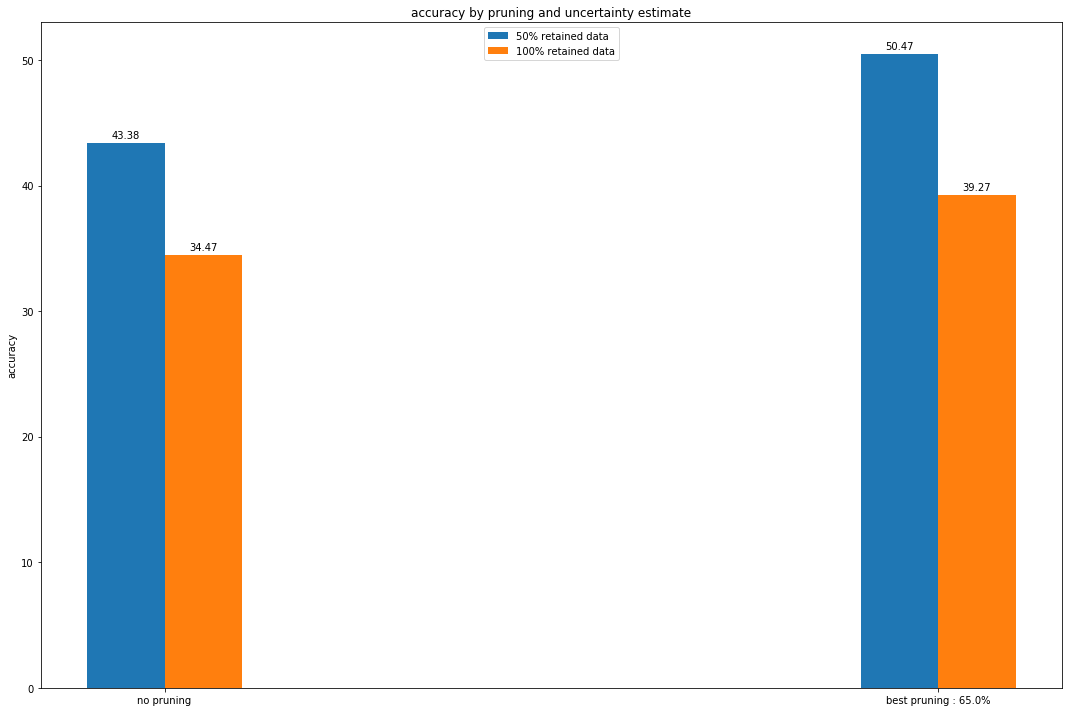

In [27]:
model = MLP_32_64_cifar().cuda()
best_pr = plot_4_points_of_interest(seed, model, epochs, test_size)

#### Interpolation

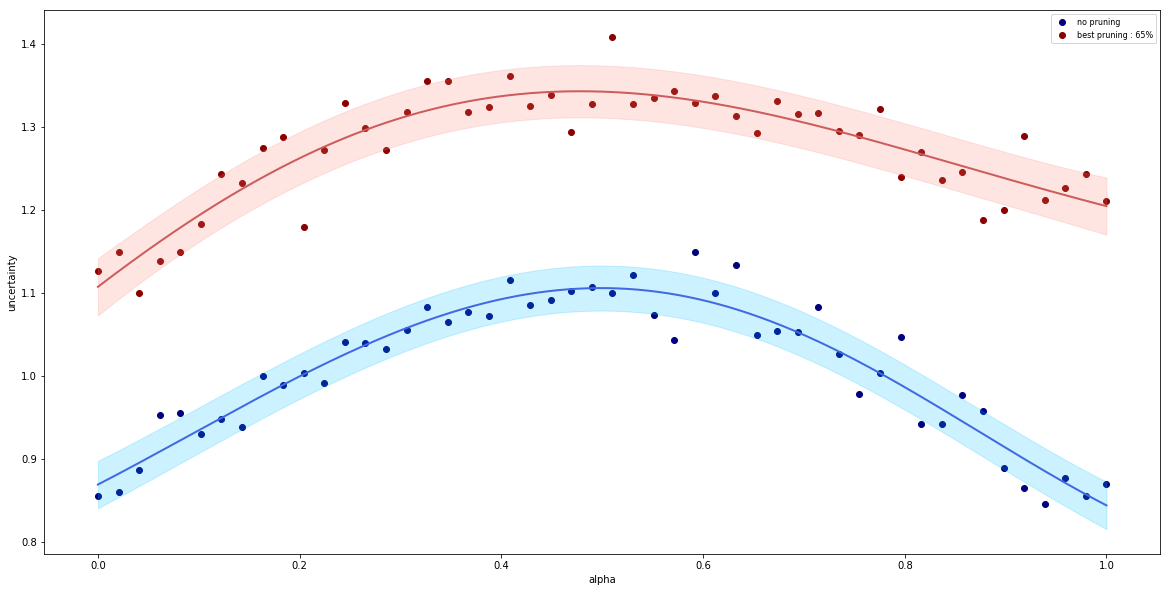

In [28]:
model =  MLP_32_64_cifar().cuda()

uncertainty = uncertainty_on_interpolation(model, test_loader, epochs, best_pr, seed)

plot_interpolation(uncertainty)

### ConvNets

In [ ]:
class CNN_64_64_cifar(nn.Module):
    def __init__(self):
        super(CNN_64_64_cifar, self).__init__()

        self.conv1 = MaskedConv2d(3, 64, kernel_size=5, padding=2, stride=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(2)

        self.conv2 = MaskedConv2d(64, 64, kernel_size=5, padding=2, stride=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(2)

        self.linear3 = MaskedLinear(8*8*64,10)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x, training):
        out = self.maxpool1(F.dropout(self.relu1(self.conv1(x)),0.5, training=training))
        out = self.maxpool2(F.dropout(self.relu2(self.conv2(out)),0.5, training=training))
        out = out.view(out.size(0), -1)
        out = F.dropout(self.linear3(out),0.5,training=training)
        out = self.softmax(out)
        return out
    
    def get_name(self):
        return 'CNN_64_64_cifar'

    def set_masks(self, masks, mode):
        # Should be a less manual way to set masks
        # Leave it for the future
        if mode == 'filters':
            self.conv1.set_mask(masks[0])
            self.conv2.set_mask(masks[1])
        if mode == 'weights':
            self.conv1.set_mask(masks[0])
            self.conv2.set_mask(masks[1])
            self.linear3.set_mask(masks[2])

#### Pre-training : 30 epochs

In [ ]:
for s in tqdm(seed):
    torch.manual_seed(s)
    model = CNN_64_64_cifar().cuda()
    train(model,train_loader, test_loader, batch_size, epochs)
    torch.save(model.state_dict(), F"models/{model.get_name()}_pretrain{epochs}_seed{s}.pkl")

#### Pruning : iteratively and retrained 10 epochs

In [ ]:
model = CNN_64_64_cifar.cuda()

for s in tqdm(seed):
    prune_network(model, train_loader, test_loader, batch_size, epochs, s, mode)

#### Uncertainty vs sparsity

In [ ]:
for s in tqdm(seed):
    model = CNN_64_64_cifar.cuda()
    save_stats(model, epochs, test_loader, 'test_set', s, test_size)
    save_stats(model, epochs, validation_loader, 'validation_set', s, validation_size)
    
plot_accuracy_on_test_and_validation_set(seed, model, epochs, test_size)

In [ ]:
save_averaged_behaviour(seed, epochs, model, 'test_set', test_size)
save_averaged_behaviour(seed, epochs, model, 'validation_set', validation_size)
       
plot_averaged_behaviour(model, ['test_set','validation_set'], epochs,seed)

In [ ]:
model = CNN_64_64_cifar.cuda()
best_pr = plot_4_points_of_interest(seed, model, epochs, test_size)

#### Interpolation

In [ ]:
model = CNN_64_64_cifar.cuda()

uncertainty = uncertainty_on_interpolation(model, test_loader, epochs, best_pr, seed)

plot_interpolation(uncertainty)